In [ ]:
# runtime
import timeit

# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# preprocessing
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer

# Ml model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

np.warnings.filterwarnings('ignore')

In [ ]:
# read dataset from csv file
dataset = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Project/data.csv")

In [ ]:
dataset.shape

(6819, 96)

In [ ]:
# check null, NA or duplicate values in the dataset
dataset.isnull().sum()

Bankrupt?                                                   0
 ROA(C) before interest and depreciation before interest    0
 ROA(A) before interest and % after tax                     0
 ROA(B) before interest and depreciation after tax          0
 Operating Gross Margin                                     0
                                                           ..
 Liability to Equity                                        0
 Degree of Financial Leverage (DFL)                         0
 Interest Coverage Ratio (Interest expense to EBIT)         0
 Net Income Flag                                            0
 Equity to Liability                                        0
Length: 96, dtype: int64

In [ ]:
# check the datatype of the features
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

In [ ]:
# Use a random forest classifier
# Model based feature selection uses a supervised machine learning model to judge the importance of each feature, 
# and keeps only the most important ones.
# training set
X = dataset.iloc[:,1:].values
y = dataset.iloc[:,0].values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
# determining optimal number of features
n_features = [10, 20, 30, 40]
for i in n_features:
    # Building the model based feature selection
    select = RFE(RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=i)

    select.fit(X_train, y_train)

    mask = select.get_support()

    X_train_rfe = select.transform(X_train)
    X_test_rfe = select.transform(X_test)

    score = RandomForestClassifier().fit(X_train_rfe, y_train).score(X_test_rfe, y_test)
    
    print("Test score: {:.3f}".format(score), " number of features: {}".format(i))

Test score: 0.968  number of features: 10
Test score: 0.972  number of features: 20
Test score: 0.971  number of features: 30
Test score: 0.971  number of features: 40


In [ ]:
# There's not so much difference between the scores with different features. We are going to work with 20 features
select = RFE(RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=20)

select.fit(X_train, y_train)

mask = select.get_support()

X_train_rfe = select.transform(X_train)
X_test_rfe = select.transform(X_test)

score = RandomForestClassifier().fit(X_train_rfe, y_train).score(X_test_rfe, y_test)

print("Test score: {:.3f}".format(score), " number of features: {}".format(20))

features = pd.DataFrame({'features':list(dataset.iloc[:,1:].keys()), 'select':list(mask)})
features = list(features[features['select']==True]['features'])
features.append('Bankrupt?')


Test score: 0.972  number of features: 20


In [ ]:
# show the DataFrame after feature selection to work with it's stats
data = dataset[features]
data

,Non-industry income and expenditure/revenue,Interest-bearing debt interest rate,Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Per Share Net profit before tax (Yuan ¥),Net Value Growth Rate,Interest Expense Ratio,Total debt/Total net worth,Borrowing dependency,Net profit before tax/Paid-in capital,Fixed Assets Turnover Frequency,Allocation rate per person,Cash/Total Assets,Cash/Current Liability,Net Income to Total Assets,Net Income to Stockholder's Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability,Bankrupt?
0,0.302646,7.250725e-04,0.147950,0.147950,0.169141,0.138736,0.000327,0.629951,0.021266,0.390284,0.137757,1.165007e-04,0.037135,0.004094,1.473360e-04,0.716845,0.827890,0.026601,0.564050,0.016469,1
1,0.303556,6.470647e-04,0.182251,0.182251,0.208944,0.169918,0.000443,0.635172,0.012502,0.376760,0.168962,7.190000e+08,0.012335,0.014948,1.383910e-03,0.795297,0.839969,0.264577,0.570175,0.020794,1
2,0.302035,7.900790e-04,0.177911,0.193713,0.180581,0.142803,0.000396,0.629631,0.021248,0.379093,0.148036,2.650000e+09,0.141016,0.000991,5.340000e+09,0.774670,0.836774,0.026555,0.563706,0.016474,1
3,0.303350,4.490449e-04,0.154187,0.154187,0.193722,0.148603,0.000382,0.630228,0.009572,0.379743,0.147561,9.150000e+09,0.021320,0.018851,1.010646e-03,0.739555,0.834697,0.026697,0.564663,0.023982,1
4,0.303475,6.860686e-04,0.167502,0.167502,0.212537,0.168412,0.000439,0.636055,0.005150,0.375025,0.167461,2.935211e-04,0.023988,0.014161,6.804636e-04,0.795016,0.839973,0.024752,0.575617,0.035490,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,0.303510,1.790179e-04,0.175045,0.175045,0.216602,0.172102,0.000450,0.631415,0.006655,0.373823,0.171111,1.429781e-04,0.006312,0.099481,5.071548e-03,0.799927,0.840359,0.027064,0.566193,0.029890,0
6815,0.303520,2.370237e-04,0.181324,0.181324,0.216697,0.172780,0.000445,0.631489,0.004623,0.372505,0.171805,6.051982e-04,0.003401,0.080337,4.727181e-03,0.799748,0.840306,0.027009,0.566018,0.038284,0
6816,0.303512,0.000000e+00,0.269521,0.269521,0.210929,0.173232,0.000435,0.630612,0.001392,0.369637,0.172287,1.024298e-03,0.002774,0.412885,8.821248e-02,0.797778,0.840138,0.026791,0.565158,0.097649,0
6817,0.303498,2.110211e-04,0.213392,0.213392,0.228326,0.185584,0.000529,0.630731,0.003816,0.369649,0.182498,2.330013e-04,0.007489,0.112238,7.133218e-03,0.811808,0.841084,0.026822,0.565302,0.044009,0


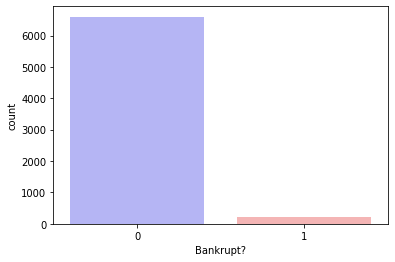

Bankrupt?
0    6599
1     220
dtype: int64

In [ ]:
# Descriptive Analysis
sns.countplot(data=data, x='Bankrupt?', palette='bwr')
plt.show()
data.groupby('Bankrupt?').size()

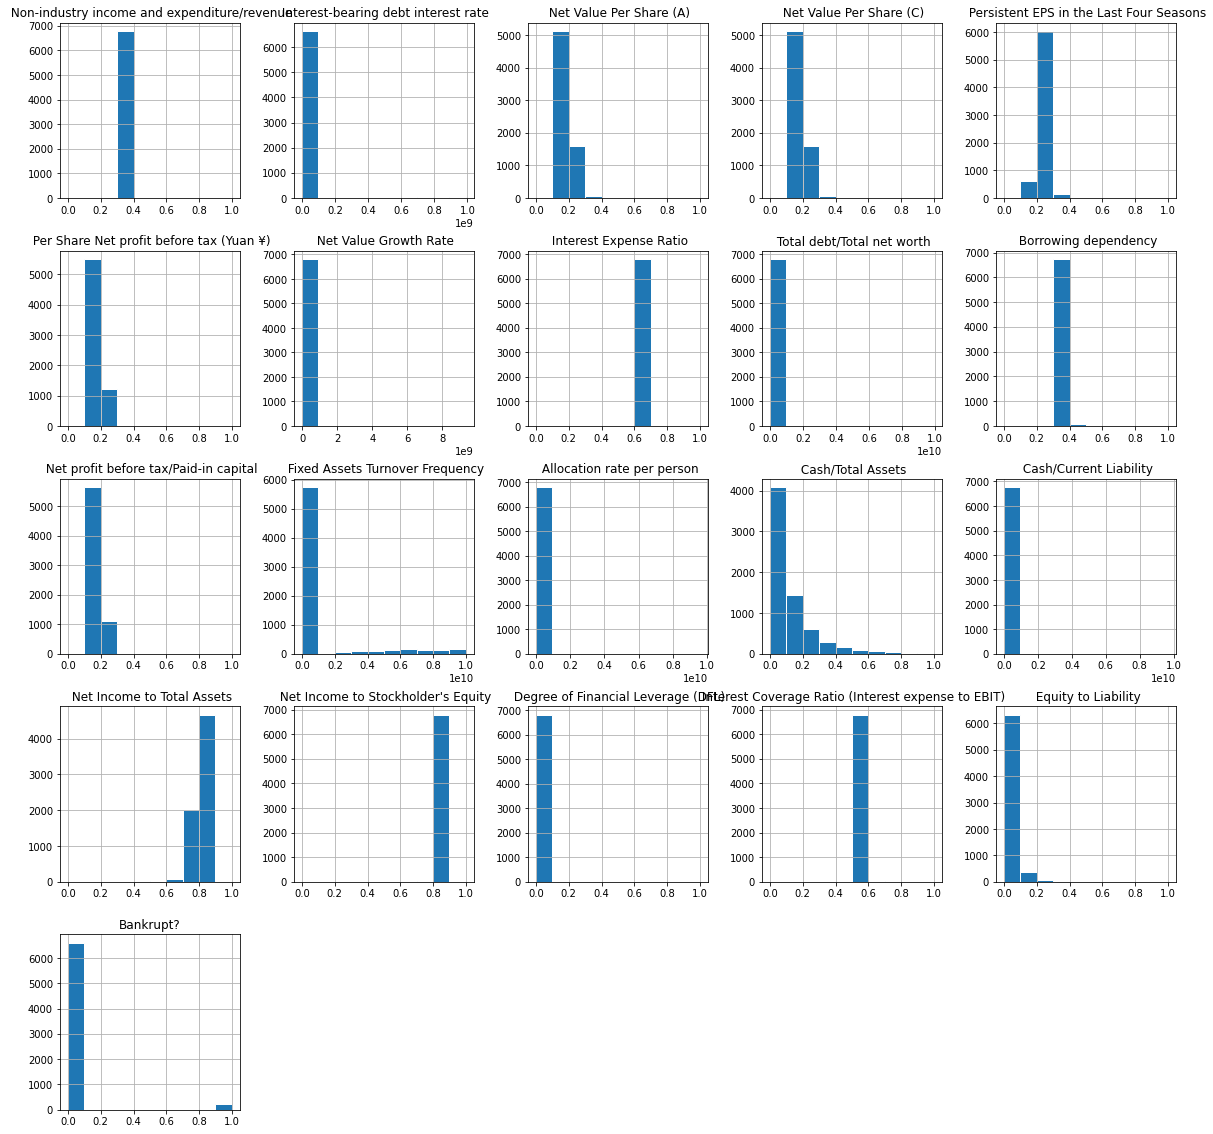

In [ ]:
# We have highly unbalanced data, this is a problem since the machine learning algorithm could be making prediction 
# based mainly on data majority.that's the reason we got so good reasults in previous analysis.
# we are going and try oversampling the data: making synthetic data out of the smaller sample (1)
data.hist(figsize=(20,20), edgecolor='white')
plt.show()


In [ ]:
# Most of the data is rich on outliers, and in some other the values are located in just one bin. 
# Let's take a closer look at ' Non-industry income and expenditure/revenue'
bins = pd.cut(data[' Non-industry income and expenditure/revenue'], bins=10)
bins = pd.DataFrame(bins)
bins.value_counts()

 Non-industry income and expenditure/revenue
(0.3, 0.4]                                      6794
(0.2, 0.3]                                        20
(-0.001, 0.1]                                      2
(0.9, 1.0]                                         1
(0.7, 0.8]                                         1
(0.4, 0.5]                                         1
(0.8, 0.9]                                         0
(0.6, 0.7]                                         0
(0.5, 0.6]                                         0
(0.1, 0.2]                                         0
dtype: int64

Rows with outliers: 6819
Rows withou outliers: 6631
information lost = 188 rows


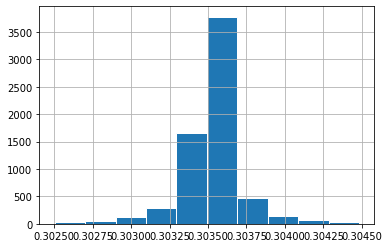

In [ ]:
lower = data[' Non-industry income and expenditure/revenue'] >0.3025
upper = data[' Non-industry income and expenditure/revenue'] <0.3045

close = data[lower & upper]
print('Rows with outliers: {}'.format(data.shape[0]))
print('Rows withou outliers: {}'.format(close.shape[0]))
print('information lost = {} rows'.format(data.shape[0]-close.shape[0]))
close[' Non-industry income and expenditure/revenue'].hist(edgecolor='white')

In [ ]:
# The distribution does have a normal distribution but is highly influenced by the outliers.
# Therefore, when analysing the data, will be better to use the median as our analysis tool for central measures
display(data.describe())
data.shape

,Non-industry income and expenditure/revenue,Interest-bearing debt interest rate,Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Per Share Net profit before tax (Yuan ¥),Net Value Growth Rate,Interest Expense Ratio,Total debt/Total net worth,Borrowing dependency,Net profit before tax/Paid-in capital,Fixed Assets Turnover Frequency,Allocation rate per person,Cash/Total Assets,Cash/Current Liability,Net Income to Total Assets,Net Income to Stockholder's Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability,Bankrupt?
count,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000
mean,0.303623,1.644801e+07,0.190633,0.190672,0.228813,0.184361,1.566212e+06,0.630991,4.416337e+06,0.374654,0.182715,1.008596e+09,1.125579e+07,0.124095,3.715999e+07,0.807760,0.840402,0.027541,0.565358,0.047578,0.032263
std,0.011163,1.082750e+08,0.033474,0.033480,0.033263,0.033180,1.141594e+08,0.011238,1.684069e+08,0.016286,0.030785,2.477557e+09,2.945063e+08,0.139251,5.103509e+08,0.040332,0.014523,0.015668,0.013214,0.050014,0.176710
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.303466,2.030203e-04,0.173613,0.173676,0.214711,0.170370,4.409689e-04,0.630612,3.007049e-03,0.370168,0.169376,2.330013e-04,4.120529e-03,0.033543,1.973008e-03,0.796750,0.840115,0.026791,0.565158,0.024477,0.000000
50%,0.303525,3.210321e-04,0.184400,0.184400,0.224544,0.179709,4.619555e-04,0.630698,5.546284e-03,0.372624,0.178456,5.930942e-04,7.844373e-03,0.074887,4.903886e-03,0.810619,0.841179,0.026808,0.565252,0.033798,0.000000
75%,0.303585,5.325533e-04,0.199570,0.199612,0.238820,0.193493,4.993621e-04,0.631125,9.273293e-03,0.376271,0.191607,3.652371e-03,1.502031e-02,0.161073,1.280557e-02,0.826455,0.842357,0.026913,0.565725,0.052838,0.000000
max,1.000000,9.900000e+08,1.000000,1.000000,1.000000,1.000000,9.330000e+09,1.000000,9.940000e+09,1.000000,1.000000,9.990000e+09,9.570000e+09,1.000000,9.650000e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


(6819, 21)

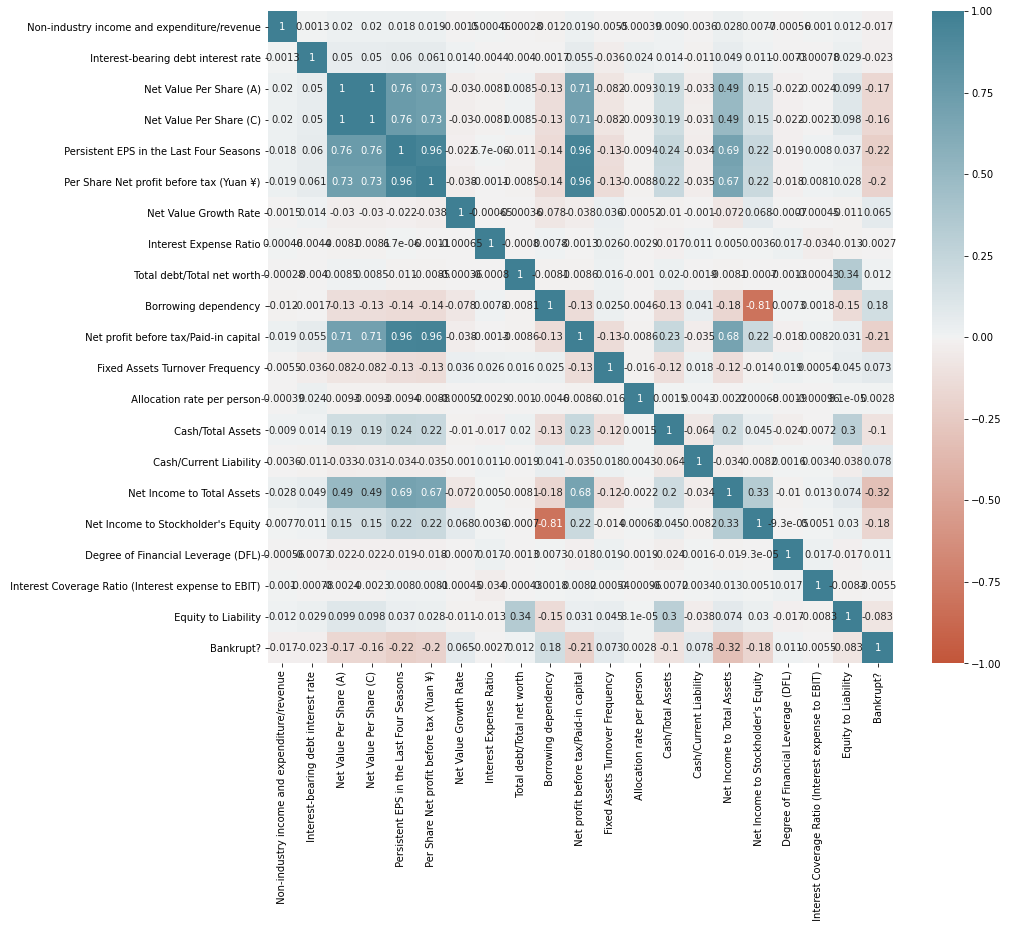

In [ ]:
# Check Correlations
fig, ax = plt.subplots(figsize=(14,12))

sns.heatmap(data.corr(), vmin=-1, vmax=1, cmap=sns.diverging_palette(20, 220, as_cmap=True), annot=True)

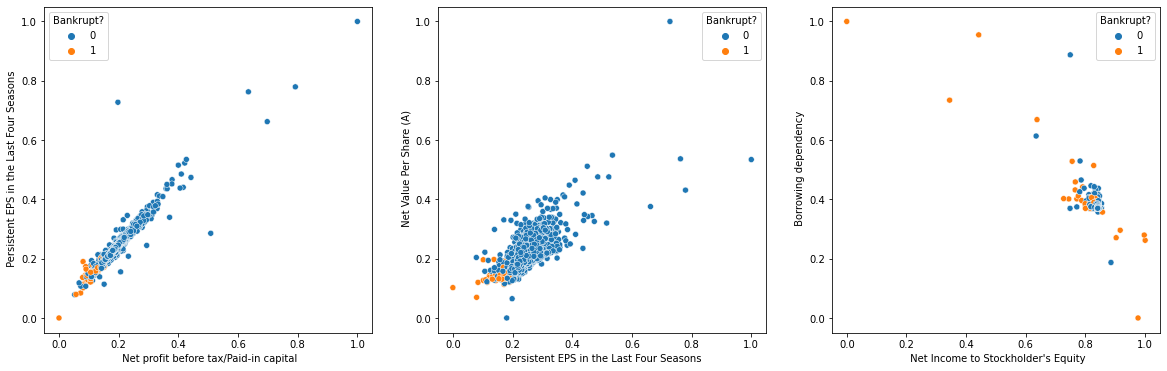

In [ ]:
# We have some interesting correlations. Let's inspect the top 3 and see if we can find any bankruptcy pattern
fig, ax = plt.subplots(1,3, figsize=(20, 6))

sns.scatterplot(data=data, x=' Net profit before tax/Paid-in capital', y=' Persistent EPS in the Last Four Seasons', hue='Bankrupt?', ax=ax[0])
sns.scatterplot(data=data, x=' Persistent EPS in the Last Four Seasons', y=' Net Value Per Share (A)', hue='Bankrupt?', ax=ax[1])
sns.scatterplot(data=data, x=" Net Income to Stockholder's Equity", y=' Borrowing dependency', hue='Bankrupt?', ax=ax[2])

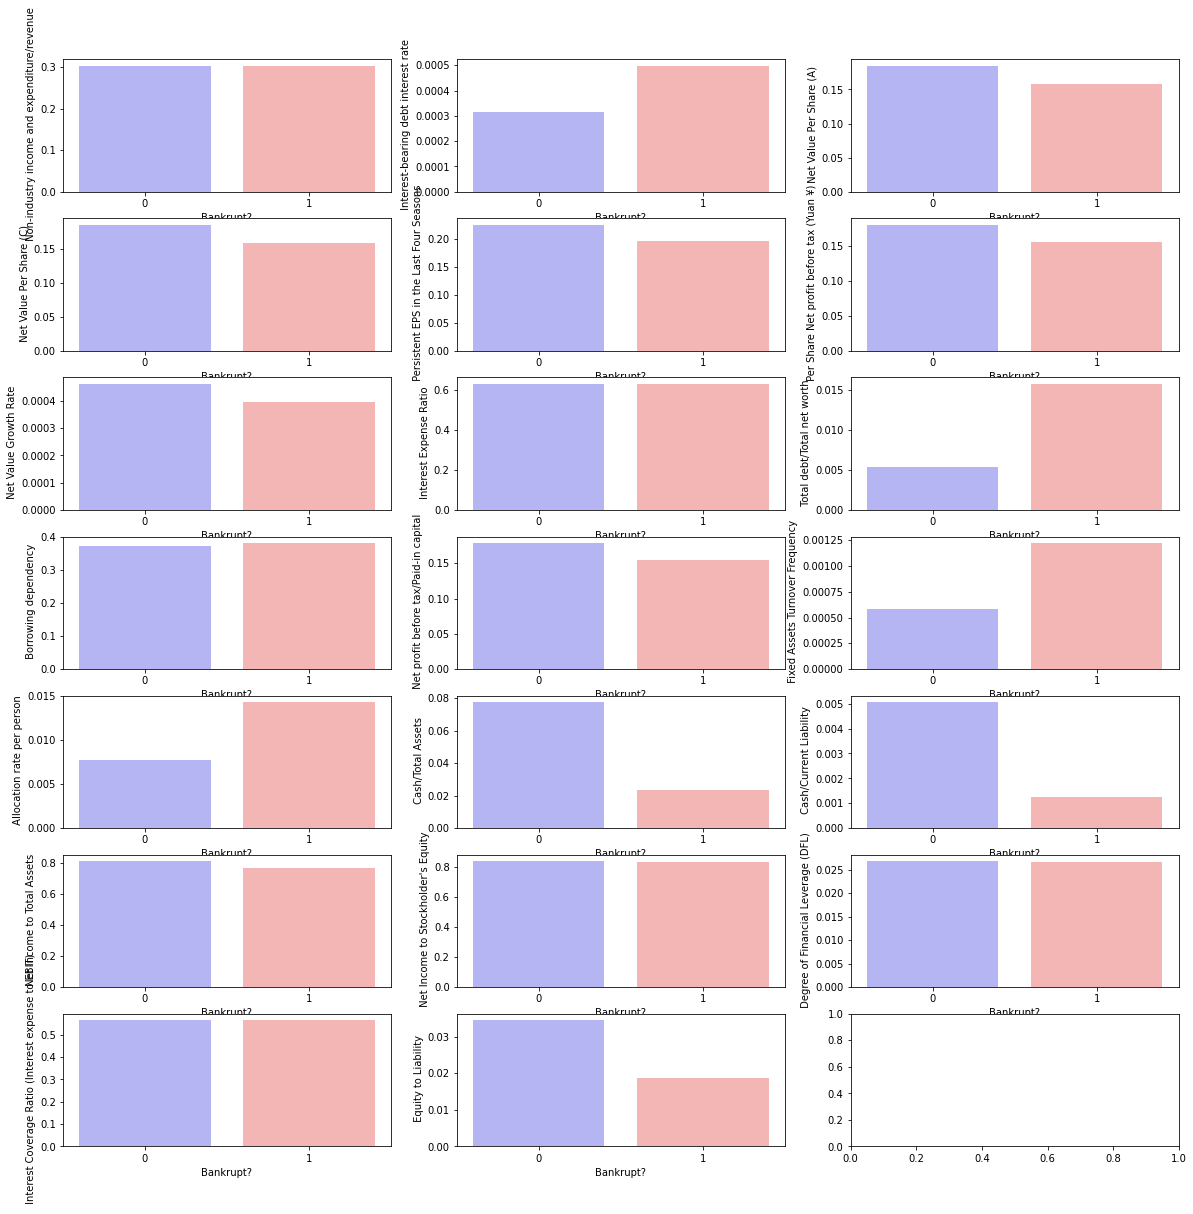

,Bankrupt?,Non-industry income and expenditure/revenue,Interest-bearing debt interest rate,Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Per Share Net profit before tax (Yuan ¥),Net Value Growth Rate,Interest Expense Ratio,Total debt/Total net worth,Borrowing dependency,Net profit before tax/Paid-in capital,Fixed Assets Turnover Frequency,Allocation rate per person,Cash/Total Assets,Cash/Current Liability,Net Income to Total Assets,Net Income to Stockholder's Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability
0,0,0.303527,0.000317,0.185074,0.185074,0.225111,0.180236,0.000463,0.630703,0.005377,0.372474,0.179021,0.000583,0.007734,0.077684,0.005070,0.811492,0.841232,0.026810,0.565259,0.034486
1,1,0.303347,0.000499,0.158021,0.158021,0.195944,0.155306,0.000396,0.630283,0.015723,0.382655,0.154012,0.001225,0.014310,0.023755,0.001266,0.766297,0.836707,0.026689,0.564712,0.018662


In [ ]:
# Let's compare the median of bankrupt and not bankrupt companies of each feature to further see if there is tendency
central = data.groupby('Bankrupt?').median().reset_index()
features = list(central.keys()[1:])

fig, ax = plt.subplots(7,3, figsize=(20,20))

ax = ax.ravel()
position = 0

for i in features:
    sns.barplot(data=central, x='Bankrupt?', y=i, ax=ax[position], palette='bwr')
    position += 1
    
plt.show()
display(central)

In [ ]:
# Predicting bankruptcy with KNN
model = ['Bankrupt?', ' Net profit before tax/Paid-in capital', ' Persistent EPS in the Last Four Seasons', " Interest-bearing debt interest rate", " Total debt/Total net worth", " Fixed Assets Turnover Frequency", " Cash/Total Assets", " Equity to Liability"]
model = data[model]
X = model.iloc[:,1:].values
y = model.iloc[:,0].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

best_n = 0
best_training = 0
best_test = 0

for i in range(1, 20):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    
    training = knn.score(X_train, y_train)
    test = knn.score(X_test, y_test)
    
    if test > best_test:
        best_n = i
        best_training = training
        best_test = test

print("best number of neighbors: {}".format(best_n))
print("best training set score : {:.3f}".format(best_training))
print("best test set score: {:.3f}".format(best_test))

best number of neighbors: 7
best training set score : 0.970
best test set score: 0.970


In [ ]:
start = timeit.default_timer()

knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)
print("training set score : {:.2f}".format(knn.score(X_train, y_train)))
print("test set score: {:.2f}".format(knn.score(X_test, y_test)))

stop = timeit.default_timer()
print('Time: ', stop - start)  

training set score : 0.97
test set score: 0.97
Time:  0.4058462449993385
